In [5]:
import os
import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Get test results

TEST_ROOT = "./results/metrics"
FIGS_ROOT = "./results/figs"
LOGS_ROOT = "./results/logs"

MODEL_NAME_READABLE2STD = {
    "Train on Original": {"A10"},
    "Train on Uniform Noise": {"A11"},
    r"Train on Rotated 90$\degree$": {"A12"},
    "Train on Ring Artifact": {"A13"},
    r"Train on all but Rotated 90$\degree$": {"C11"},
    "Train on all but Ring Artifact": {"C10"},
    r"DANN ($\mathcal{S}=\text{Original}, \mathcal{T}=\text{Rotated 90}\degree$)": {"D20"},
    r"DANN ($\mathcal{S}=\text{Original}, \mathcal{T}=\text{Ring Artifact}$)": {"D21"},
}

METRIC_NAME_READABLE2COL = {
    "Test Accuracy (Labels)": {"eval_accuracy_branch1", "eval_accuracy"},
    "Test Macro Precision (Labels)": {"eval_precision_branch1", "eval_precision"},
    "Test Macro Recall (Labels)": {"eval_recall_branch1", "eval_recall"},
    "Test Macro F1 (Labels)": {"eval_f1_branch1", "eval_f1"},
}

TESTSET_NAME_PUBLISHED2INDEX = {
    "Original": {"undistorted", "original"},
    "Uniform Noise": {"uniform", "uniform_noise"},
    r"Rotated 90$\degree$": {"rotate_90deg", "rotate"},
    "Ring Artifact": {"ring_artifact", "ring_data"},
}

FONTSIZE_L=23
FONTSIZE_S=18

def get_key_from_valueset(d: dict[str, set[str]], v: str):
    for k in d.keys():
        if v in d[k]:
            return k
    return None

def reverse_dict(d: dict[str, set[str]]) -> dict[str, str]:
    r = {}
    for k, vset in d.items():
        for v in vset:
            r[v] = k
    return r

In [6]:
# Reformat the D experiments
def csv_allfolds_to_eachfold(allfold_csv_fp: str, eachfold_csv_root: str):
    """Reformat a csv containing all k folds to k separate csv's in the expected format"""

    df = pd.read_csv(allfold_csv_fp)

    df[["Fold", "Dataset"]] = df["Dataset"].str.extract(r"(Fold_\d+)_(.*)")

    df = df.rename(columns=reverse_dict(METRIC_NAME_READABLE2COL))
    
    # Split and save CSVs
    for fold, subset in df.groupby("Fold"):
        subset.to_csv(os.path.join(eachfold_csv_root, f"{fold}.csv"), index=False)

fp_allfold_to_eachfold = {
    "D20_allfolds/D20_cv_test_metrics_v2.csv": "D20/",
    "D21_allfolds/D21_cv_test_metrics_v2.csv": "D21/",
}

for allfold_csv_fp, eachfold_csv_root in fp_allfold_to_eachfold.items():
    csv_allfolds_to_eachfold(
        os.path.join(TEST_ROOT, allfold_csv_fp),
        os.path.join(TEST_ROOT, eachfold_csv_root),
    )

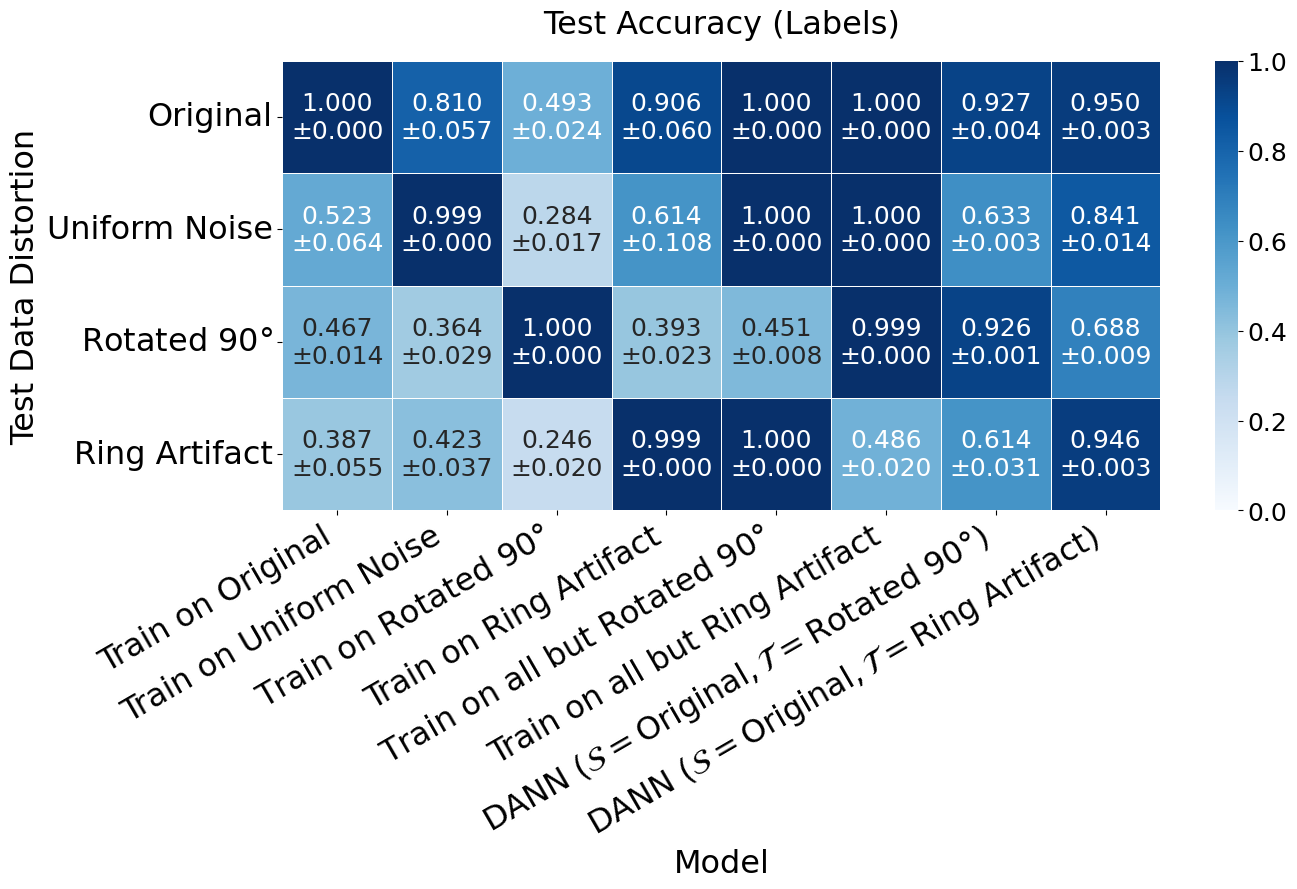

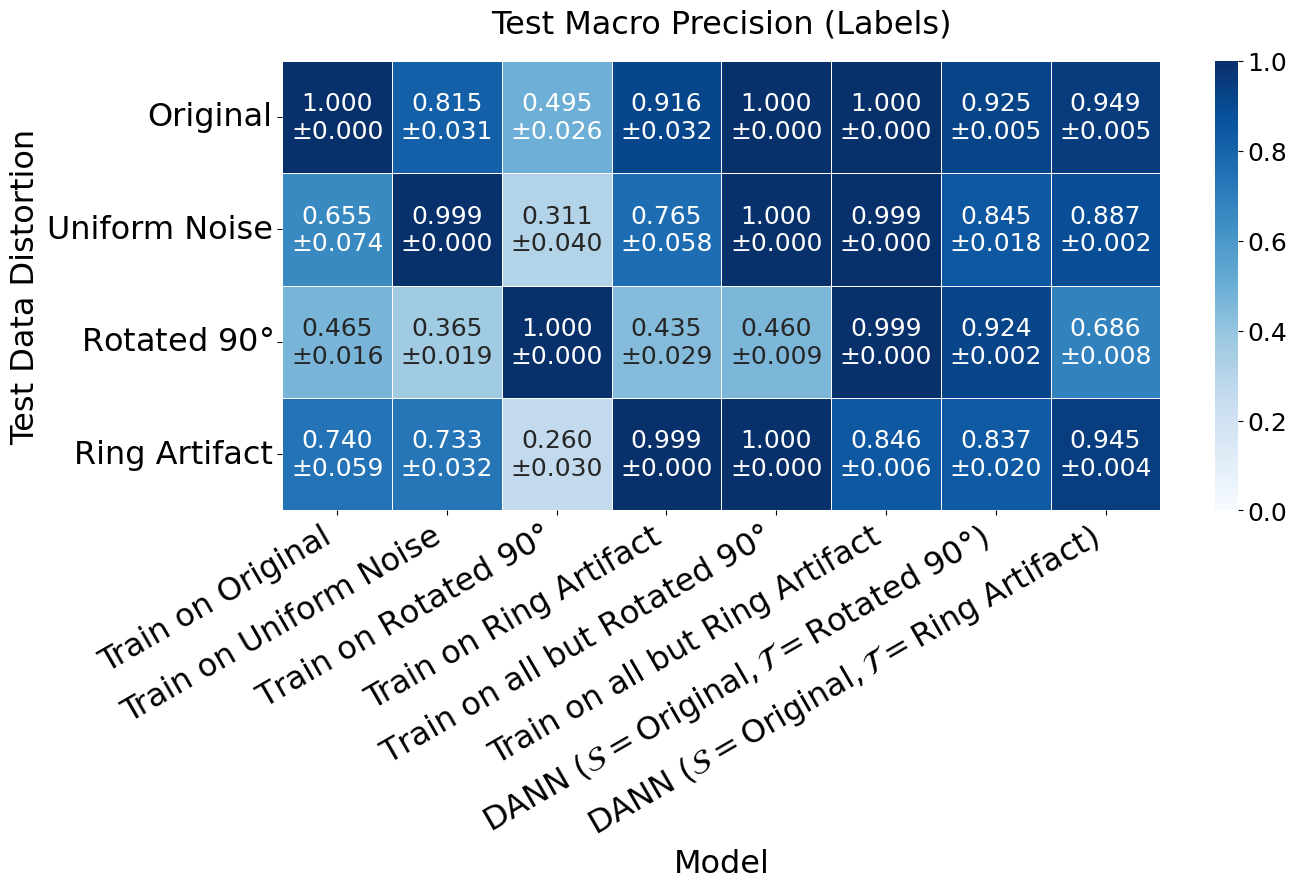

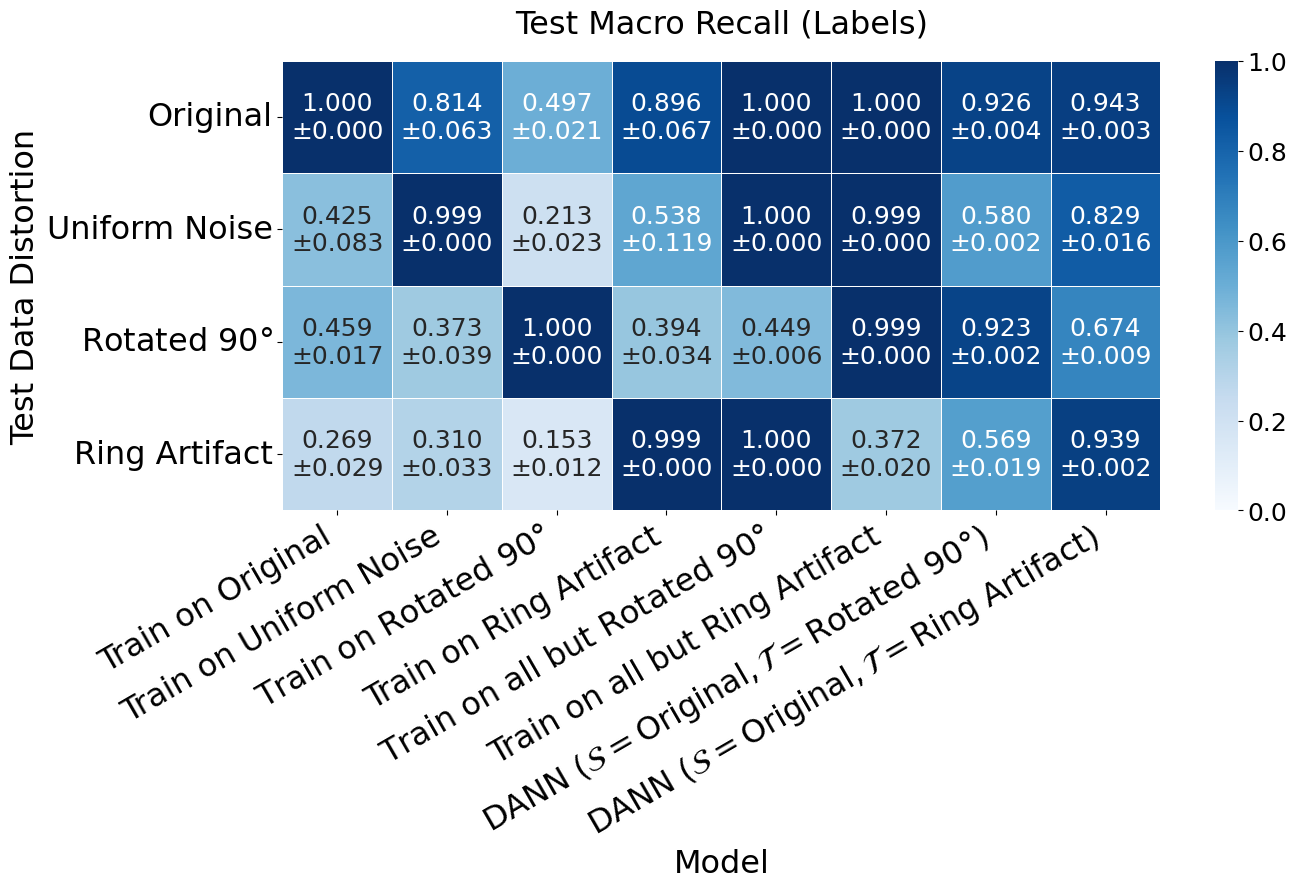

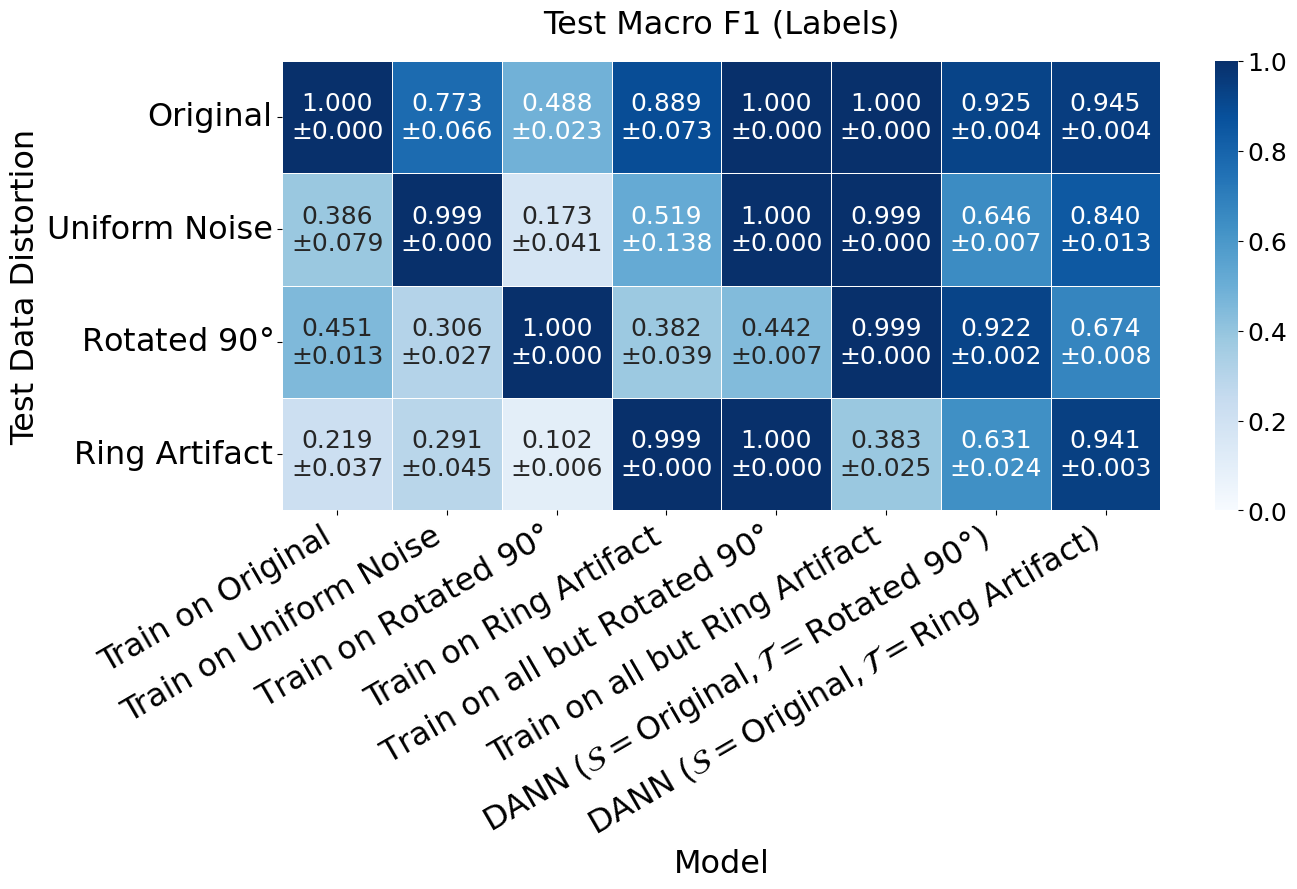

In [8]:

def mean_std_dfs_to_heatmap(mean_df, std_df, ttl, vmin=0, vmax=1, figsize=None):
    if figsize==None:
        figsize=(10,6)

    plusminus_df = mean_df.map(lambda m: f"{m:.3f}") + "\n±" + std_df.map(lambda s: f"{s:.3f}")
    
    # Plot heatmap
    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        mean_df,
        cmap="Blues",
        annot=plusminus_df,
        fmt="", # Keep format from above
        linewidths=0.5,
        vmin=vmin,
        vmax=vmax,
        annot_kws={"size": FONTSIZE_S}
    )
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=FONTSIZE_S)

    plt.title(ttl, pad=20, fontsize=FONTSIZE_L)
    plt.xlabel("Model", fontsize=FONTSIZE_L)
    plt.ylabel("Test Data Distortion", fontsize=FONTSIZE_L)
    plt.xticks(rotation=30, ha='right', fontsize=FONTSIZE_L)
    plt.yticks(rotation=0, fontsize=FONTSIZE_L)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGS_ROOT, ttl + ".png"))
    plt.show()

def create_kfold_test_matrices(figsize: tuple[int, int]):
    # Collect all relevant metrics from files
    metric_tables = {}
    for stat in ["mean", "std"]:
        metric_tables[stat] = {}
        for metric_name_readable in METRIC_NAME_READABLE2COL.keys():
            metric_tables[stat][metric_name_readable] = {}
            for model_name_readable in MODEL_NAME_READABLE2STD.keys():
                # Find a folder with the test results
                model_name_std = [x for x in MODEL_NAME_READABLE2STD[model_name_readable]][0]
                fold_test_result_fps = [os.path.join(TEST_ROOT,model_name_std,x) for x in os.listdir(os.path.join(TEST_ROOT,model_name_std)) if (".csv" in x)]

                fold_metrics = {}
                for fold_num in range(len(fold_test_result_fps)):
                    fold_test_result_fp = fold_test_result_fps[fold_num]
                    df = pd.read_csv(fold_test_result_fp, index_col="Dataset")
                    df = df.rename(index=reverse_dict(TESTSET_NAME_PUBLISHED2INDEX), columns=reverse_dict(METRIC_NAME_READABLE2COL))
                    df = df.loc[TESTSET_NAME_PUBLISHED2INDEX.keys()]

                    if metric_name_readable in df.columns:
                        fold_metrics[fold_num] = df[metric_name_readable]
        
                df = pd.DataFrame(fold_metrics)
                if stat == "mean":
                    metric_tables[stat][metric_name_readable][model_name_readable] = df.mean(axis=1)
                elif stat == "std":
                    metric_tables[stat][metric_name_readable][model_name_readable] = df.std(axis=1)
                else:
                    assert False

    dfs = {}
    for stat in ["mean", "std"]:
        dfs[stat] = {}
        for metric_name_readable, metric_dict in metric_tables[stat].items():
            df = pd.DataFrame(metric_dict)
            dfs[stat][metric_name_readable] = df
    
    for metric_name_readable in METRIC_NAME_READABLE2COL.keys():
        mean_df = dfs["mean"][metric_name_readable]
        std_df = dfs["std"][metric_name_readable]
        # if "Loss" in metric_name_readable:
        #     mean_std_dfs_to_heatmap(mean_df, std_df, metric_name_readable, vmin=None, vmax=None)
        # elif "Domain" in metric_name_readable:
        #     mean_std_dfs_to_heatmap(mean_df.dropna(axis=1, how='any'), std_df.dropna(axis=1, how='any'), metric, figsize=(4.5,6))
        # else:
        mean_std_dfs_to_heatmap(mean_df, std_df, metric_name_readable, figsize=figsize)

test_results = create_kfold_test_matrices((14,9))

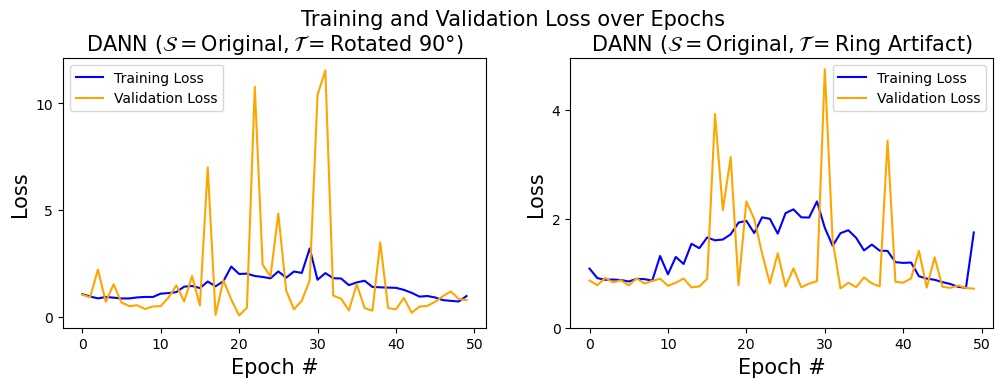

In [4]:
# Get training & appropriate val loss curves
def get_losses(fname):
    df = pd.read_csv(os.path.join(LOGS_ROOT, fname))
    df["loss"] = df["loss"].ffill()
    df = df[df["epoch"] % 1 == 0]
    n_epochs = len(df["loss"])
    assert n_epochs == len(df["eval_loss"])
    epochs = list(range(n_epochs))
    return epochs, df["loss"], df["eval_loss"]

# Get training loss curves
epochs, d20_train, d20_val = get_losses("D20_parabolic_increasing_lambda_scheduler_metrics.csv")
_, d21_train, d21_val = get_losses("D21_parabolic_increasing_lambda_scheduler_metrics.csv")

supttl = "Training and Validation Loss over Epochs"
d20_ttl = r"DANN ($\mathcal{S}=\text{Original}, \mathcal{T}=\text{Rotated 90}\degree$)"
d21_ttl = r"DANN ($\mathcal{S}=\text{Original}, \mathcal{T}=\text{Ring Artifact}$)"

fig, axes = plt.subplots(1, 2, figsize=(12, 3.5), sharey=False)

FONTSIZE=15

axes[0].plot(epochs, d20_train, color="blue", label="Training Loss")
axes[0].plot(epochs, d20_val, color="orange", label="Validation Loss")
axes[0].set_title(d20_ttl, fontsize=FONTSIZE)
axes[0].set_xlabel("Epoch #", fontsize=FONTSIZE)
axes[0].set_ylabel("Loss", fontsize=FONTSIZE)
axes[0].set_yticks([0.0, 5.0, 10.0])
axes[0].legend()

axes[1].plot(epochs, d21_train, color="blue", label="Training Loss")
axes[1].plot(epochs, d21_val, color="orange", label="Validation Loss")
axes[1].set_title(d21_ttl, fontsize=FONTSIZE)
axes[1].set_xlabel("Epoch #", fontsize=FONTSIZE)
axes[1].set_ylabel("Loss", fontsize=FONTSIZE)
axes[1].set_yticks([0.0, 2.0, 4.0])
axes[1].legend()

fig.suptitle(supttl, y=1.02, fontsize=FONTSIZE)

savepath = os.path.join(FIGS_ROOT, f"{supttl}.png")
fig.savefig(savepath, bbox_inches='tight')
plt.show()
plt.rcParams["xtick.labelsize"] = FONTSIZE
plt.rcParams["ytick.labelsize"] = FONTSIZE